# Sexism Detection Using Machine Learning

In [1]:
import pandas as pd

df = pd.read_csv('sexist.csv')
df.head()

,text,label
0,[USER] Leg day is easy. Hot girls who wear min...,1
1,I get a new pussy every other week or whenever...,1
2,I agree with that but at the same time I know ...,1
3,O come on there's no way any men are attracted...,1
4,democrats from Minnesota (leftist muzzie shith...,1


In [2]:
id2label = {0: 'not sexist', 1: 'sexist'}
label2id = {v:k for k, v in id2label.items()}

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
X = tokenizer.texts_to_sequences(df['text'])

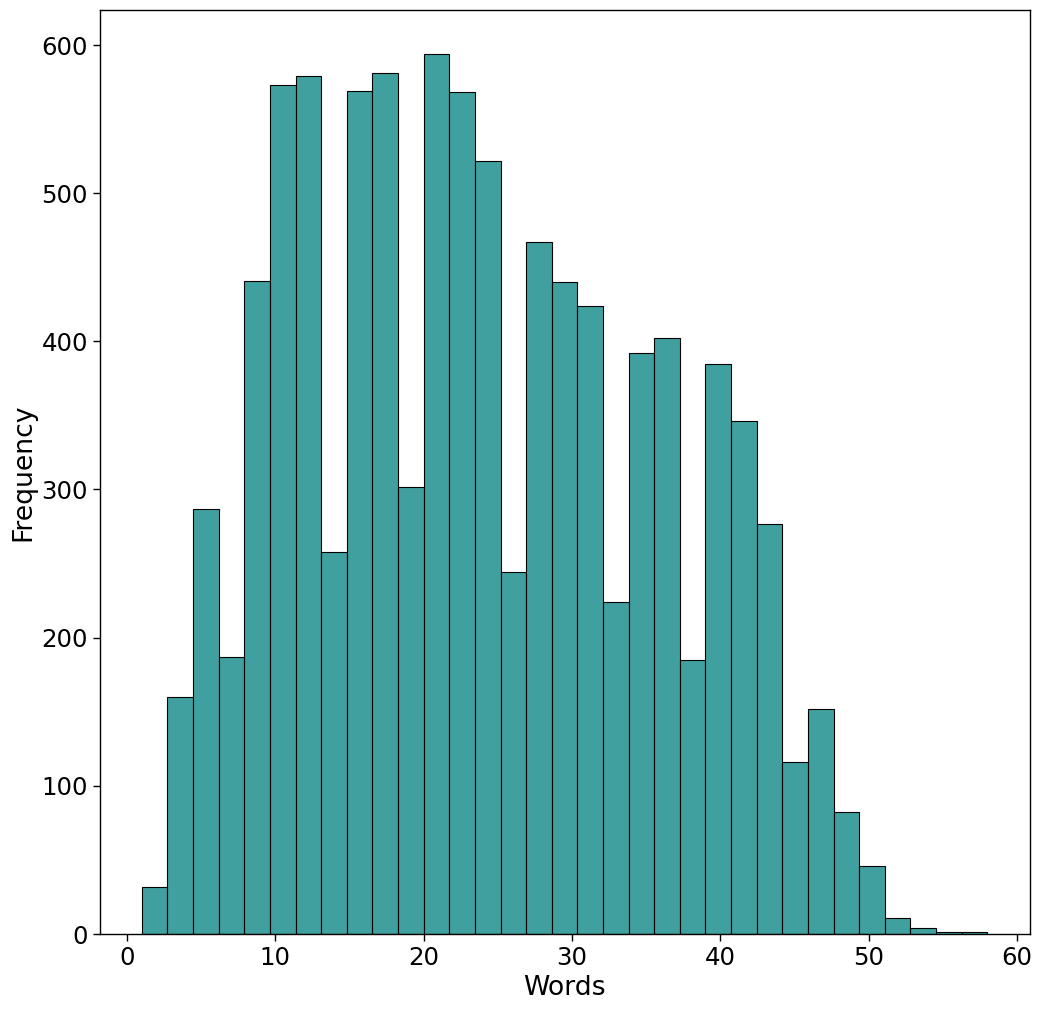

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

lengths = pd.Series([len(x) for x in X])

with sns.plotting_context("paper", font_scale=2):
    plt.figure(figsize=(12, 12))
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    sns.histplot(lengths, color='teal')
    plt.savefig('wordhist', dpi=100, bbox_inches='tight')

In [5]:
max_len = 30
X = pad_sequences(X, maxlen=max_len)
y = df['label'].ravel()
y = y.reshape(-1, 1)

In [6]:
import tensorflow as tf
import numpy as np
import os
import random


def set_seed(seed):
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)


seed = 4
vocab_size = 39970
embed_size = 100

In [7]:
from sklearn.model_selection import StratifiedKFold, train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.2, random_state=seed, stratify=y)

set_seed(seed)

In [8]:
%%time
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

adb = AdaBoostClassifier()
param_grid = {"n_estimators": [10, 50, 100,
                               500, 100], "learning_rate": [1, .1, .01]}
gs = GridSearchCV(adb, param_grid, cv=5, verbose=1, n_jobs=-1)
gs.fit(X_train, y_train.ravel())
gs.best_params_

Fitting 5 folds for each of 15 candidates, totalling 75 fits
CPU times: total: 13.7 s
Wall time: 50.8 s


{'learning_rate': 1, 'n_estimators': 500}

In [9]:
adb = AdaBoostClassifier(learning_rate=1, n_estimators=500)
adb.fit(X_train, y_train.ravel())
adb_y = adb.predict(X_test)
adb.score(X_test, y_test)

0.8046676813800101

In [10]:
from sklearn.metrics import classification_report

print(classification_report(y_test, adb_y, digits=4))

              precision    recall  f1-score   support

           0     0.8247    0.7810    0.8023      1000
           1     0.7861    0.8290    0.8070       971

    accuracy                         0.8047      1971
   macro avg     0.8054    0.8050    0.8046      1971
weighted avg     0.8057    0.8047    0.8046      1971



In [11]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression


pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', LogisticRegression())
])
param_grid = {'clf__solver': ['newton-cg', 'lbfgs', 'liblinear'],
              'clf__C': [100, 10, 1.0, 0.1, 0.01], 'clf__max_iter': [10000]}
gs = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, n_jobs=-1)
gs.fit(X_train, y_train.ravel())
gs.best_params_

Fitting 5 folds for each of 15 candidates, totalling 75 fits
CPU times: total: 234 ms
Wall time: 502 ms


{'clf__C': 0.1, 'clf__max_iter': 10000, 'clf__solver': 'newton-cg'}

In [12]:
log_reg = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', LogisticRegression(C=0.1, solver='newton-cg', max_iter=10000))
])
log_reg.fit(X_train, y_train.ravel())
log_reg_y = log_reg.predict(X_test)
print(classification_report(y_test, log_reg_y, digits=4))

              precision    recall  f1-score   support

           0     0.5732    0.4620    0.5116      1000
           1     0.5382    0.6457    0.5871       971

    accuracy                         0.5525      1971
   macro avg     0.5557    0.5539    0.5494      1971
weighted avg     0.5560    0.5525    0.5488      1971



In [13]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.6706    0.4560    0.5429      1000
           1     0.5786    0.7693    0.6605       971

    accuracy                         0.6104      1971
   macro avg     0.6246    0.6127    0.6017      1971
weighted avg     0.6253    0.6104    0.6008      1971



c:\Users\csa\mambaforge\envs\tf\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
%%time
from sklearn.neighbors import KNeighborsClassifier


clf = KNeighborsClassifier()
param_grid = {'n_neighbors':  [1, 2, 3, 4],
              'p': [1, 2], 'leaf_size': [10, 20, 30, 40]}
gs = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
gs.fit(X_train, y_train.ravel())
print(gs.best_params_)

{'leaf_size': 10, 'n_neighbors': 3, 'p': 1}
CPU times: total: 594 ms
Wall time: 8.32 s


In [15]:
from sklearn.preprocessing import StandardScaler

clf = KNeighborsClassifier(n_neighbors=3, p=1, leaf_size=10)
knn = Pipeline([('scaler', StandardScaler()), ('clf', clf)])
knn.fit(X_train, y_train.ravel())
knn_y = knn.predict(X_test)
print(classification_report(y_test, knn_y, digits=4))

              precision    recall  f1-score   support

           0     0.6777    0.6750    0.6764      1000
           1     0.6667    0.6694    0.6680       971

    accuracy                         0.6722      1971
   macro avg     0.6722    0.6722    0.6722      1971
weighted avg     0.6723    0.6722    0.6723      1971

